In [1]:
import tensorflow as tf

2023-12-13 19:50:50.225866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 19:50:50.225910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 19:50:50.227800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 19:50:50.236509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

# with tf.device('/device:GPU:0'):
#     print('a')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-12-13 19:50:52.510077: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 19:50:52.517838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 19:50:52.518112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="ticks")


In [4]:
df = pd.read_csv('out2.csv')
df

,user_id,order_number,days_since_prior_order,product_id
0,1,1,0.0,196
1,1,1,0.0,14084
2,1,1,0.0,12427
3,1,1,0.0,26088
4,1,1,0.0,26405
...,...,...,...,...
32434484,206209,13,210.0,14197
32434485,206209,13,210.0,38730
32434486,206209,13,210.0,31477
32434487,206209,13,210.0,6567


Топ 10 пар uid + pid, по которым больше всего данных
```
user_id  product_id
141736   25133
41356    38652 
17997    4210
41356    6583
103593   28204
120897   12013
41356    29671
84478    31981
99707    24852
98085    196
```

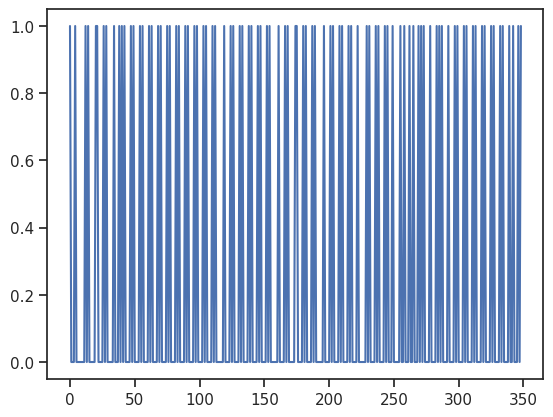

<Axes: >

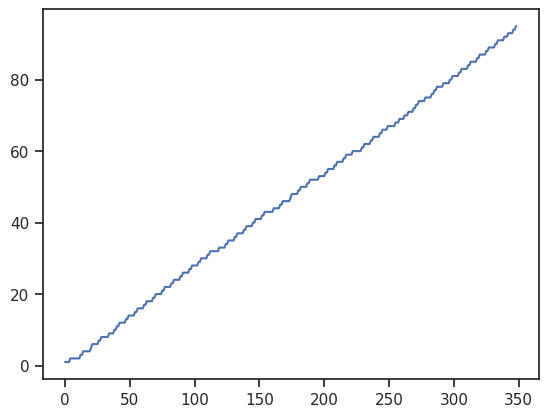

In [5]:
uid = 98085
pid = 196

dfdf = df[(df['user_id'] == uid) & (df['product_id'] == pid)] 

by_days = []

for idx, (_, a) in enumerate(dfdf.iterrows()):
    # print(idx, int(a.days_since_prior_order))
    current_day = int(a.days_since_prior_order)
    by_days += [0] * (current_day - len(by_days) + 1)
    by_days[current_day] = 1

from itertools import accumulate
by_days_prefix = list(accumulate(by_days))

sns.lineplot(by_days)
plt.show()
sns.lineplot(by_days_prefix)

In [6]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
fourier = CalendarFourier(freq="A", order=0)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=pd.date_range("2000-1-1", freq="D", periods=len(by_days_prefix)),
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

In [7]:
X = dp.in_sample()  # create features for dates in tunnel.index
X["day"] = X.index.dayofweek 
X["week"] = X.index.to_period().week
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",day,week,dayofyear,year
2000-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,52,1,2000
2000-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,6,52,2,2000
2000-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,3,2000
2000-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,4,2000
2000-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1,5,2000
...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-10,1.0,345.0,1.0,0.0,0.0,0.0,0.0,0.0,6,49,345,2000
2000-12-11,1.0,346.0,0.0,1.0,0.0,0.0,0.0,0.0,0,50,346,2000
2000-12-12,1.0,347.0,0.0,0.0,1.0,0.0,0.0,0.0,1,50,347,2000
2000-12-13,1.0,348.0,0.0,0.0,0.0,1.0,0.0,0.0,2,50,348,2000


## Не префикс сумма

In [8]:
y = by_days.copy()
y

[1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,


In [9]:
amn = 60
X_train = X[:amn]
y_train = y[:amn]
X_test = X[amn:]
y_test = y[amn:]

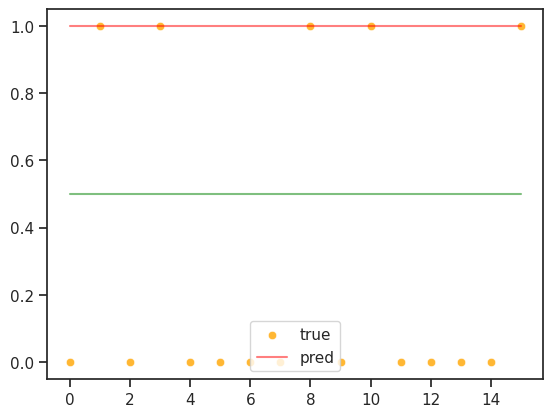

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import r2_score

model = MultinomialNB()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_train_pred_r = list(map(round, y_train_pred))
y_test_pred_r = list(map(round, y_test_pred))

# sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.8, color='blue')
sns.scatterplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred[:16], label='pred', alpha=0.5, color='red')
sns.lineplot([0.5] * 16, alpha=0.5, color='green')

# Предсказание классов на тестовом наборе данных
y_pred = model.predict(X_test)

0.9894618657616725

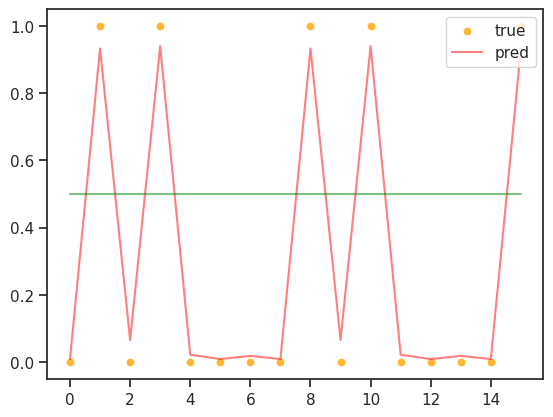

In [11]:
# БУСТИНГ!
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

model = GradientBoostingRegressor(n_estimators=55, learning_rate=0.1, max_depth=4, random_state=666)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_train_pred_r = list(map(round, y_train_pred))
y_test_pred_r = list(map(round, y_test_pred))

# sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.8, color='blue')
sns.scatterplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred[:16], label='pred', alpha=0.5, color='red')
sns.lineplot([0.5] * 16, alpha=0.5, color='green')

r2_score(y_test[:10], y_test_pred[:10])

0.7487914862914855

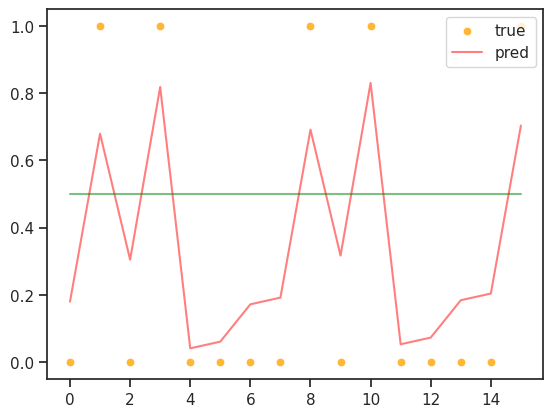

In [17]:
# линейная АГРЕССИЯ!!!!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_train_pred_r = list(map(round, y_train_pred))
y_test_pred_r = list(map(round, y_test_pred))

# sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.8, color='blue')
sns.scatterplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred[:16], label='pred', alpha=0.5, color='red')
sns.lineplot([0.5] * 16, alpha=0.5, color='green')

r2_score(y_test[:10], y_test_pred[:10])

Epoch 1/128
2/2 - 1s - loss: 30849.2207 - 1s/epoch - 640ms/step
Epoch 2/128
2/2 - 0s - loss: 3045.3508 - 9ms/epoch - 4ms/step
Epoch 3/128
2/2 - 0s - loss: 1668.1964 - 9ms/epoch - 4ms/step
Epoch 4/128
2/2 - 0s - loss: 6333.2891 - 12ms/epoch - 6ms/step
Epoch 5/128
2/2 - 0s - loss: 6551.6357 - 11ms/epoch - 6ms/step
Epoch 6/128
2/2 - 0s - loss: 3416.1147 - 9ms/epoch - 4ms/step
Epoch 7/128
2/2 - 0s - loss: 660.6241 - 10ms/epoch - 5ms/step
Epoch 8/128
2/2 - 0s - loss: 144.0045 - 11ms/epoch - 5ms/step
Epoch 9/128
2/2 - 0s - loss: 1163.5961 - 12ms/epoch - 6ms/step
Epoch 10/128
2/2 - 0s - loss: 1950.8081 - 10ms/epoch - 5ms/step
Epoch 11/128
2/2 - 0s - loss: 1632.3856 - 9ms/epoch - 5ms/step
Epoch 12/128
2/2 - 0s - loss: 632.4182 - 12ms/epoch - 6ms/step
Epoch 13/128
2/2 - 0s - loss: 44.0596 - 9ms/epoch - 5ms/step
Epoch 14/128
2/2 - 0s - loss: 229.4129 - 10ms/epoch - 5ms/step
Epoch 15/128
2/2 - 0s - loss: 603.6887 - 10ms/epoch - 5ms/step
Epoch 16/128
2/2 - 0s - loss: 587.9650 - 8ms/epoch - 4ms/ste

-10.625264991511939

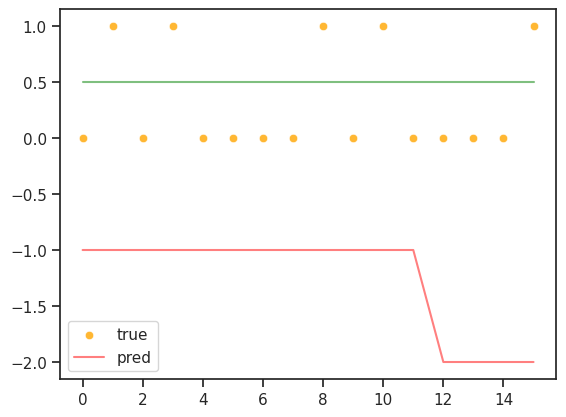

In [19]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim=12, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, pd.DataFrame(y_train), epochs=128, batch_size=32, verbose=2)

y_test_pred = model.predict(X_test)

y_test_pred_r = list(map(lambda x: x[0], y_test_pred))
y_test_pred_r = list(map(round, y_test_pred_r))

sns.scatterplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.5, color='red')
sns.lineplot([0.5] * 16, alpha=0.5, color='green')


r2_score(y_test[:10], y_test_pred[:10])

## Префикс сумма

In [20]:
y = by_days_prefix.copy()
y

[1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 26,
 26,
 26,
 26,
 26,
 27,
 27,
 28,
 28,
 28,
 28,
 28,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 33,
 33,
 34,
 34,
 35,
 35,
 35,
 35,
 35,
 36,
 36,
 37,
 37,
 37,
 37,
 37,
 38,
 38,
 39,
 39,
 39,
 39,
 39,
 40,
 40,
 41,
 41,
 41,
 41,
 41,
 42,
 42,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 44,
 44,
 44,
 44,
 44,
 45,
 45,
 46,
 46,
 46,
 46,
 46,
 46,
 47,
 48,
 48,
 48,
 48,
 48,
 49,
 49,
 50,
 50,
 50,
 50,
 50,
 51,
 51,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 53,
 53,
 53,
 53,
 53,
 54,
 54,
 55,
 55,
 55,
 55,
 55

In [38]:
amn = 60
X_train = X[:amn]
y_train = y[:amn]
X_test = X[amn:]
y_test = y[amn:]

0.868421052631579

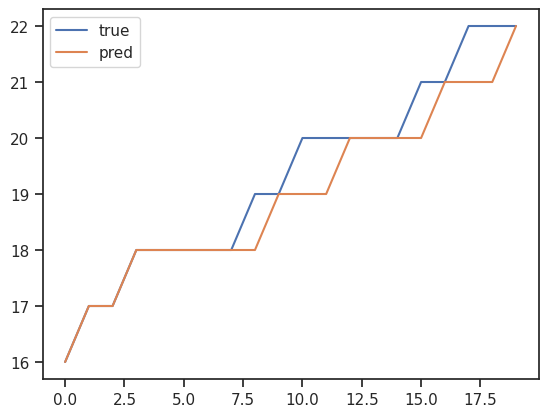

In [39]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
# X_train_list = X_train.values.tolist()

# for xt, yt in zip(X_train_list, y_train):
#     model.fit([xt], [yt])

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_train_pred = list(map(round, y_train_pred))
y_test_pred = list(map(round, y_test_pred))

sns.lineplot(y_test[:20], label='true')
sns.lineplot(y_test_pred[:20], label='pred')

r2_score(y_test[:10], y_test_pred[:10])

In [25]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(Dense(64, input_dim=12, activation='relu'))
model.add(Dense(32, activation='relu'))
# model.add(LSTM(50, input_shape=(8, 1)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, pd.DataFrame(y_train), epochs=128, batch_size=16, verbose=2)


Epoch 1/128
4/4 - 1s - loss: 928.8961 - 1s/epoch - 257ms/step
Epoch 2/128
4/4 - 0s - loss: 828.6778 - 16ms/epoch - 4ms/step
Epoch 3/128
4/4 - 0s - loss: 619.9750 - 18ms/epoch - 4ms/step
Epoch 4/128
4/4 - 0s - loss: 208.2515 - 17ms/epoch - 4ms/step
Epoch 5/128
4/4 - 0s - loss: 126.2216 - 16ms/epoch - 4ms/step
Epoch 6/128
4/4 - 0s - loss: 176.5996 - 17ms/epoch - 4ms/step
Epoch 7/128
4/4 - 0s - loss: 97.9518 - 14ms/epoch - 3ms/step
Epoch 8/128
4/4 - 0s - loss: 50.5642 - 15ms/epoch - 4ms/step
Epoch 9/128
4/4 - 0s - loss: 61.2401 - 13ms/epoch - 3ms/step
Epoch 10/128
4/4 - 0s - loss: 51.1247 - 17ms/epoch - 4ms/step
Epoch 11/128
4/4 - 0s - loss: 31.4934 - 15ms/epoch - 4ms/step
Epoch 12/128
4/4 - 0s - loss: 24.9008 - 14ms/epoch - 4ms/step
Epoch 13/128
4/4 - 0s - loss: 22.3240 - 15ms/epoch - 4ms/step
Epoch 14/128
4/4 - 0s - loss: 25.9712 - 17ms/epoch - 4ms/step
Epoch 15/128
4/4 - 0s - loss: 19.5923 - 16ms/epoch - 4ms/step
Epoch 16/128
4/4 - 0s - loss: 16.3916 - 15ms/epoch - 4ms/step
Epoch 17/12

10/10 [==============================] - 0s 2ms/step


0.42159475995319895

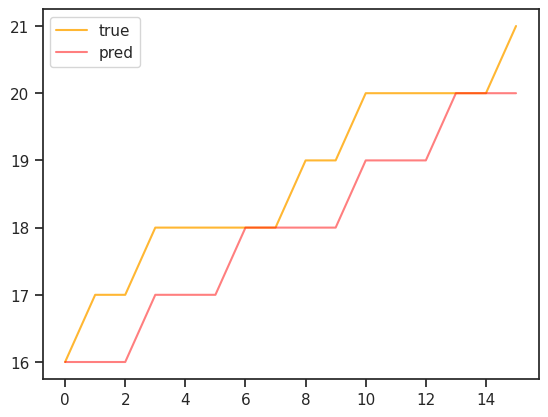

In [26]:
y_test_pred = model.predict(X_test)

y_test_pred_r = list(map(lambda x: x[0], y_test_pred))
y_test_pred_r = list(map(round, y_test_pred_r))

sns.lineplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.5, color='red')

r2_score(y_test[:10], y_test_pred[:10])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# from keras.losses import MeanSquaredError

model = Sequential()
model.add(Dense(24, input_dim=10, activation='relu'))
model.add(Dense(24, input_dim=10, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=2)

y_pred = model.predict(X_test)

rate_model(y_test, y_pred)